In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import rasterio as rio
import rasterstats 
from rasterio.plot import show
import os
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
import seaborn as sns
from geopy.distance import geodesic

In [105]:
# reading shape files and mapping the route 
def read_shape(shapefile, route):
    fp = shapefile
    dat = gpd.read_file(fp)
    da = dat[dat['ROUTE_NUM'] == route]
    
    # da.to_file("da.shp")
    # points = folium.GeoJson(da.to_json())
    # map = folium.Map(location = [47.6, -122.3], zoom_start = 12).add_child(points)
    
    return(da)
    
# reading raster files and extract elevation 
def extract_elev(shapefile, route, rasterfile):
    da = read_shape(shapefile, route)
    raw_elev = pd.DataFrame(rasterstats.gen_point_query(da, rasterfile))
    elev = [x for x in raw_elev.iloc[0,:] if x is not None] 
    print('The number of points: {}' .format(len(elev)))
    elev_meter = np.array(elev) * 0.3048
    return(elev_meter)


# extracting points from linestring 
def extract_point(shapefile, route):
    da = read_shape(shapefile, route)
    geoms = da.geometry.values # list of shapely geometries
    geometry = geoms[0] # shapely geometry
    geoms = [mapping(geoms[0])]
    ge = np.array(geoms[0]['coordinates'])[:,[0,1]]

    coord = []
    for i in range(len(ge)):
            coord.append([ge[i][1], ge[i][0]])

    return(coord)


# map points 
def map_point(shapefile, route):
    coord = extract_point(shapefile, route)
    loca = pd.DataFrame(np.array(coord)).values.tolist()

    map = folium.Map(location=[47.6, -122.3], zoom_start=12)
    for point in range(0, len(loca)):
        folium.Marker(loca[point]).add_to(map)
    
    return(map)


# distance measure 
def dist_measure(shapefile, route):
    coord = extract_point(shapefile, route)
    dis = []
    for i in range(len(coord)-1):
        dis.append(geodesic(coord[i],coord[i+1]).m)

    dist = np.insert(np.cumsum(dis), 0, 0)
    
    return(dis, dist)

# route plots 
def profile_plot(shapefile, route, rasterfile):
    dis, dist = dist_measure(shapefile, route)
    elev = extract_elev(shapefile, route, rasterfile)
    stress = np.insert(abs(np.diff(elev)/ dis), 0, 0)
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    
    ax[0].plot(dist, elev, label= 'elevation', color='b', linewidth=4)
    ax[0].set_ylabel('Elevation (meter)', color='b')
    ax[0].tick_params('y', colors='b')
    ax[0].legend()
    ax[0].grid()
    
    # ax[1] = ax.twinx()
    ax[1].plot(dist, stress, label= 'stress index', color='r')
    ax[1].set_xlabel('Plain distance (meter)')
    ax[1].set_ylabel('Stress index', color='r')
    ax[1].tick_params('y', colors='r')
    ax[1].legend()
    ax[1].grid()
    
    return(elev, stress)

The number of points: 208


array([0.        , 0.01558004, 0.01199502, 0.01179236, 0.01290646,
       0.01481437, 0.00903265, 0.01235229, 0.01142904, 0.00551679,
       0.00811324, 0.00118185, 0.00889743, 0.00852617, 0.00398943,
       0.0052352 , 0.0016726 , 0.00034205, 0.0068275 , 0.0029874 ,
       0.01912448, 0.01263433, 0.03582092, 0.03117057, 0.00832164,
       0.00536445, 0.03303312, 0.0137347 , 0.04433567, 0.05317841,
       0.04972779, 0.03152369, 0.0540941 , 0.04628343, 0.04995346,
       0.04079993, 0.03488086, 0.0244718 , 0.02599962, 0.01461265,
       0.01684909, 0.01473038, 0.00183349, 0.00775346, 0.0227345 ,
       0.03815036, 0.03144233, 0.00940894, 0.01037971, 0.07375645,
       0.07499098, 0.07021047, 0.03758985, 0.00932316, 0.01290291,
       0.00828272, 0.01570251, 0.008472  , 0.01001433, 0.00083936,
       0.00959772, 0.00908925, 0.01366942, 0.00650642, 0.01300021,
       0.01767539, 0.01915585, 0.03603853, 0.02752013, 0.03407155,
       0.01213328, 0.02266884, 0.04446852, 0.04863574, 0.04391

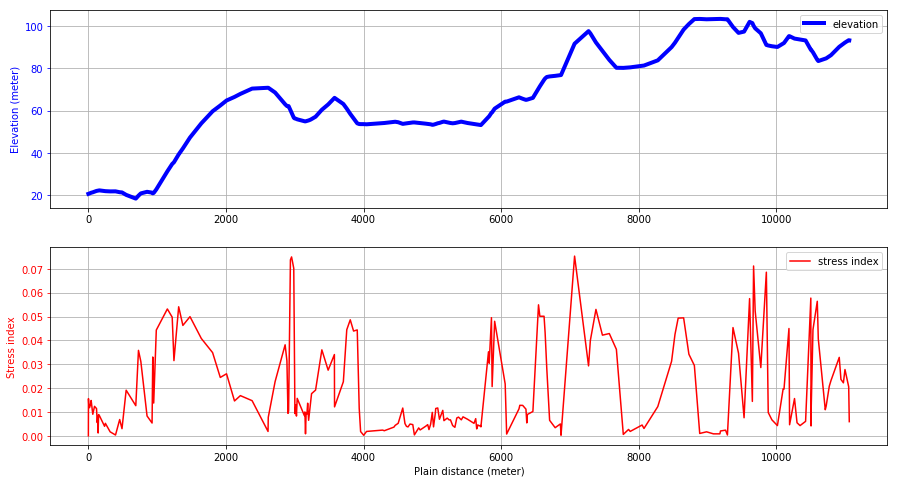

In [107]:
elev, stress =profile_plot('six_routes.shp', 45, 'seattle_dtm.tif')
stress